# 1. Import Dependencies and Data

In [1]:
!pip install tensorflow==2.10 matplotlib tensorflow-datasets ipywidgets --user

In [2]:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
# Brining in tensorflow datasets for fashion mnist 
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [6]:

ds = tfds.load('fashion_mnist', split='train')

In [7]:
ds.as_numpy_iterator().next()['label']

2

# 2. Viz Data and Build Dataset

In [8]:

import numpy as np

In [9]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

In [10]:

dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

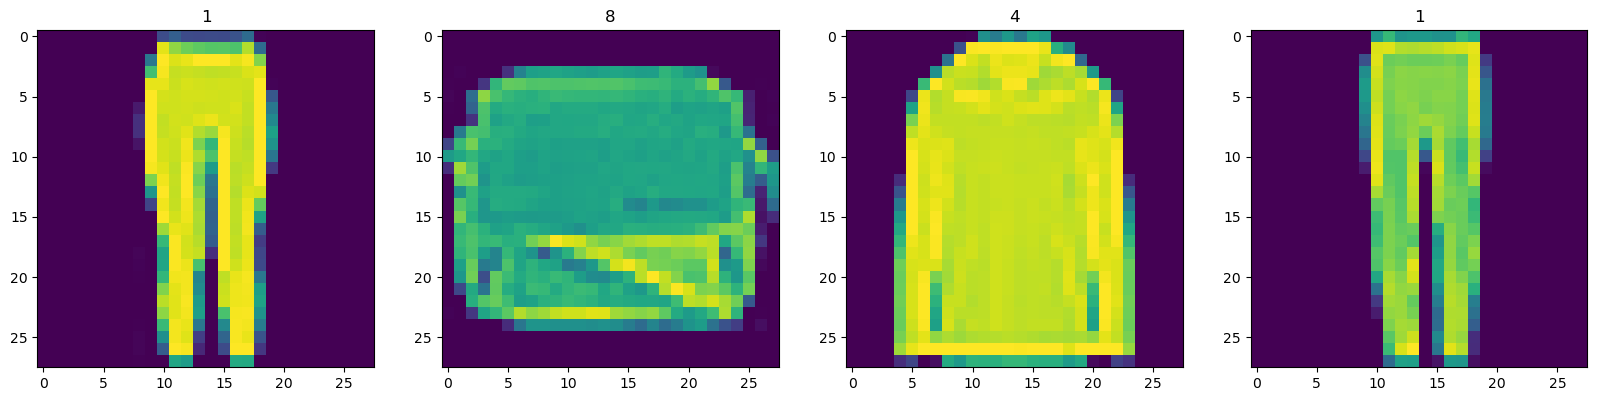

In [11]:
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx in range(4): 
    # Grab an image and label
    sample = dataiterator.next()
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(sample['image']))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(sample['label'])

In [12]:
# Scale and return images only 
def scale_images(data): 
    image = data['image']
    return image / 255

### 2.1 preprocessing the data

In [13]:
# Reload the dataset 
ds = tfds.load('fashion_mnist', split='train')
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [14]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

### 3.1 Import Modelling Components

In [15]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### 3.2 Build Generator

In [16]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [17]:
generator = build_generator()

In [18]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [19]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 1s 833ms/step


1/1 [==============================] - 0s 14ms/step


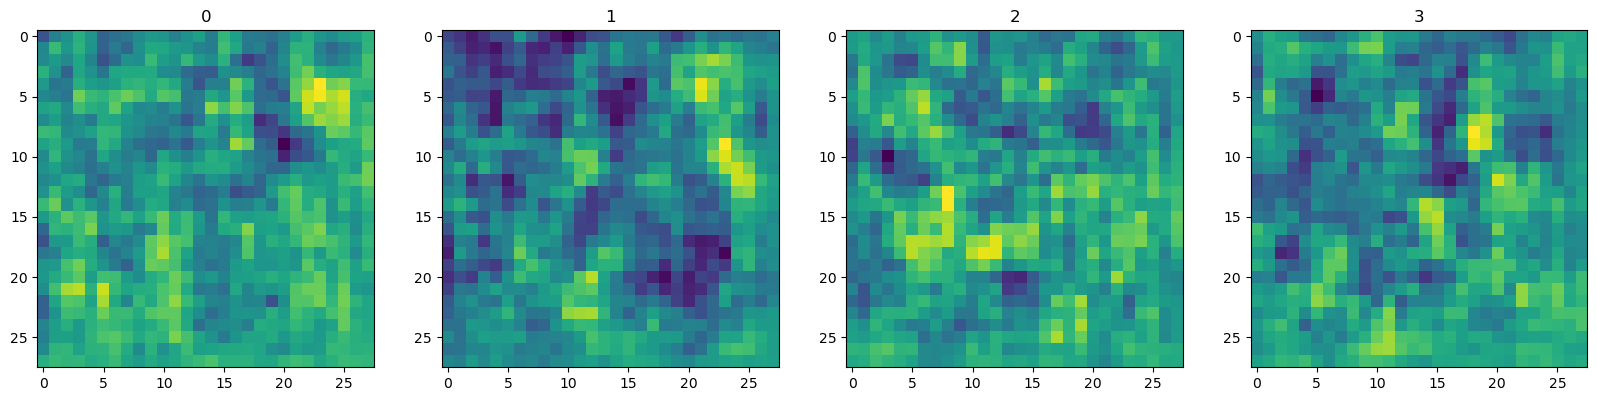

In [20]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img1 in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img1))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

### 3.3 Build Discriminator

In [21]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [22]:
discriminator = build_discriminator()

In [23]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [24]:
img.shape

(4, 28, 28, 1)

In [25]:
discriminator.predict(img)

1/1 [==============================] - 0s 66ms/step


array([[0.5068983 ],
       [0.5070343 ],
       [0.50708765],
       [0.50697076]], dtype=float32)

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimizers

In [26]:
# choosing adam and binary cross entropy for both gen and disc
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [27]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

### 4.2 Build Subclassed Model

In [28]:
# Importing the base model class to subclass our training step 
from tensorflow.keras.models import Model

In [29]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
       
        super().__init__(*args, **kwargs)
    

        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        # Compile with base class
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
      
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [30]:

fashgan = FashionGAN(generator, discriminator)

In [31]:

fashgan.compile(g_opt, d_opt, g_loss, d_loss)

### 4.3 Build Callback

In [32]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback



In [33]:

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save = 0
        
    

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))
        
        if self.save == 30:
            generator.save('generator.tf')
            discriminator.save('discriminator.tf')
            self.save = 0
        else:
            self.save+=1
            
        

        

In [34]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 4.3 Train 

In [35]:

hist = fashgan.fit(ds, epochs=2500, callbacks=[ModelMonitor()])

Epoch 1/2500


  6/469 [..............................] - ETA: 1:29 - d_loss: 0.6958 - g_loss: 0.7006WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0802s vs `on_train_batch_end` time: 0.0942s). Check your callbacks.


469/469 [==============================] - 98s 197ms/step - d_loss: 0.5440 - g_loss: 1.4962
Epoch 2/2500
469/469 [==============================] - 92s 196ms/step - d_loss: 0.5201 - g_loss: 1.2141
Epoch 3/2500
469/469 [==============================] - 92s 196ms/step - d_loss: 0.6987 - g_loss: 0.6972
Epoch 4/2500
469/469 [==============================] - 92s 196ms/step - d_loss: 0.6589 - g_loss: 0.7204
Epoch 5/2500
469/469 [==============================] - 92s 196ms/step - d_loss: 0.7077 - g_loss: 0.5700
Epoch 6/2500
469/469 [==============================] - 91s 195ms/step - d_loss: 0.6898 - g_loss: 0.6461
Epoch 7/2500
469/469 [==============================] - 92s 196ms/step - d_loss: 0.6941 - g_loss: 0.6353
Epoch 8/2500
469/469 [==============================] - 92s 196ms/step - d_loss: 0.6870 - g_loss: 0.6579
Epoch 9/2500
469/469 [==============================] - 92s 196ms/step - d_loss: 0.6950 - g_loss: 0.6337
Epoch 10/2500
469/469 [==============================] - 92s 196ms/s

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 93s 199ms/step - d_loss: 0.6763 - g_loss: 0.5619
Epoch 32/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6870 - g_loss: 0.5910
Epoch 33/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6470 - g_loss: 0.5727
Epoch 34/2500
469/469 [==============================] - 91s 194ms/step - d_loss: 0.6884 - g_loss: 0.6090
Epoch 35/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6856 - g_loss: 0.6287
Epoch 36/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6718 - g_loss: 0.6067
Epoch 37/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6850 - g_loss: 0.6014
Epoch 38/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6741 - g_loss: 0.6251
Epoch 39/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6962 - g_loss: 0.5781
Epoch 40/2500
469/469 [==============================] - 90s

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6883 - g_loss: 0.6460
Epoch 63/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6702 - g_loss: 0.6288
Epoch 64/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6464 - g_loss: 0.5878
Epoch 65/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6801 - g_loss: 0.6428
Epoch 66/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6713 - g_loss: 0.6367
Epoch 67/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6866 - g_loss: 0.6702
Epoch 68/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6916 - g_loss: 0.6372
Epoch 69/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6871 - g_loss: 0.6490
Epoch 70/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6919 - g_loss: 0.6287
Epoch 71/2500
469/469 [==============================] - 90s

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6745 - g_loss: 0.7155
Epoch 94/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6988 - g_loss: 0.6380
Epoch 95/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6896 - g_loss: 0.6491
Epoch 96/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.7010 - g_loss: 0.6519
Epoch 97/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6806 - g_loss: 0.6735
Epoch 98/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6808 - g_loss: 0.6822
Epoch 99/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6838 - g_loss: 0.6767
Epoch 100/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6822 - g_loss: 0.6845
Epoch 101/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6892 - g_loss: 0.6565
Epoch 102/2500
469/469 [==============================] - 

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6211 - g_loss: 0.7705
Epoch 125/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6334 - g_loss: 0.7635
Epoch 126/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6753 - g_loss: 0.6751
Epoch 127/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6436 - g_loss: 0.8254
Epoch 128/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6902 - g_loss: 0.6673
Epoch 129/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6343 - g_loss: 0.8113
Epoch 130/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6553 - g_loss: 0.6644
Epoch 131/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6771 - g_loss: 0.6786
Epoch 132/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6045 - g_loss: 0.8751
Epoch 133/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6841 - g_loss: 0.7075
Epoch 156/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6552 - g_loss: 0.7560
Epoch 157/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6493 - g_loss: 0.7977
Epoch 158/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6683 - g_loss: 0.7100
Epoch 159/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6151 - g_loss: 0.8646
Epoch 160/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.3187 - g_loss: 1.1654
Epoch 161/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6633 - g_loss: 0.5821
Epoch 162/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6069 - g_loss: 0.8918
Epoch 163/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5441 - g_loss: 1.0406
Epoch 164/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6006 - g_loss: 0.7754
Epoch 187/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6183 - g_loss: 0.8794
Epoch 188/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.3542 - g_loss: 1.3303
Epoch 189/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5753 - g_loss: 0.9083
Epoch 190/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.3074 - g_loss: 1.4630
Epoch 191/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5939 - g_loss: 0.9571
Epoch 192/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6015 - g_loss: 0.9078
Epoch 193/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6179 - g_loss: 0.8923
Epoch 194/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6388 - g_loss: 0.8193
Epoch 195/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6913 - g_loss: 0.6773
Epoch 218/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6756 - g_loss: 0.7057
Epoch 219/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6386 - g_loss: 0.7529
Epoch 220/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5838 - g_loss: 0.9154
Epoch 221/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6064 - g_loss: 0.8409
Epoch 222/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6632 - g_loss: 0.7079
Epoch 223/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6133 - g_loss: 0.7825
Epoch 224/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6466 - g_loss: 0.7329
Epoch 225/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6397 - g_loss: 0.8673
Epoch 226/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6477 - g_loss: 0.7130
Epoch 249/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6253 - g_loss: 0.8200
Epoch 250/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6141 - g_loss: 0.7270
Epoch 251/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5710 - g_loss: 1.0489
Epoch 252/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6064 - g_loss: 0.8586
Epoch 253/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5041 - g_loss: 1.1386
Epoch 254/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5657 - g_loss: 0.9520
Epoch 255/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6144 - g_loss: 0.7913
Epoch 256/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5911 - g_loss: 0.9088
Epoch 257/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6064 - g_loss: 0.8719
Epoch 280/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6413 - g_loss: 0.7826
Epoch 281/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6359 - g_loss: 0.8360
Epoch 282/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5794 - g_loss: 0.9154
Epoch 283/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6278 - g_loss: 0.7968
Epoch 284/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5613 - g_loss: 1.0239
Epoch 285/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6220 - g_loss: 0.8295
Epoch 286/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5829 - g_loss: 0.9142
Epoch 287/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6115 - g_loss: 0.8248
Epoch 288/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.5411 - g_loss: 0.8775
Epoch 311/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6310 - g_loss: 0.8306
Epoch 312/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5920 - g_loss: 0.9658
Epoch 313/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.3475 - g_loss: 1.6930
Epoch 314/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6147 - g_loss: 0.8770
Epoch 315/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5576 - g_loss: 0.9920
Epoch 316/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6221 - g_loss: 0.8808
Epoch 317/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5705 - g_loss: 0.8916
Epoch 318/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5509 - g_loss: 0.9993
Epoch 319/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.5739 - g_loss: 0.8782
Epoch 342/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6015 - g_loss: 0.7639
Epoch 343/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6240 - g_loss: 0.8342
Epoch 344/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6393 - g_loss: 0.7551
Epoch 345/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5650 - g_loss: 0.9795
Epoch 346/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5723 - g_loss: 0.7775
Epoch 347/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5350 - g_loss: 1.3418
Epoch 348/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5872 - g_loss: 0.8436
Epoch 349/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6488 - g_loss: 0.6949
Epoch 350/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6083 - g_loss: 0.8561
Epoch 373/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5668 - g_loss: 0.9612
Epoch 374/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6194 - g_loss: 0.7667
Epoch 375/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6211 - g_loss: 0.8051
Epoch 376/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.4925 - g_loss: 1.1282
Epoch 377/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5538 - g_loss: 1.1396
Epoch 378/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5557 - g_loss: 1.0077
Epoch 379/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5703 - g_loss: 0.8423
Epoch 380/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5907 - g_loss: 0.8451
Epoch 381/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6041 - g_loss: 0.8526
Epoch 404/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5856 - g_loss: 0.9432
Epoch 405/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5345 - g_loss: 0.9853
Epoch 406/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5534 - g_loss: 1.0304
Epoch 407/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5181 - g_loss: 1.1434
Epoch 408/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5466 - g_loss: 0.9332
Epoch 409/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5835 - g_loss: 0.9455
Epoch 410/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5716 - g_loss: 0.8489
Epoch 411/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5929 - g_loss: 0.9976
Epoch 412/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.2753 - g_loss: 2.8283
Epoch 435/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.2729 - g_loss: 2.8206
Epoch 436/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.2724 - g_loss: 2.8186
Epoch 437/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.2709 - g_loss: 2.8247
Epoch 438/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.2701 - g_loss: 2.8143
Epoch 439/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.2696 - g_loss: 2.8140
Epoch 440/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.2779 - g_loss: 2.7778
Epoch 441/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.3233 - g_loss: 1.5135
Epoch 442/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5203 - g_loss: 1.2091
Epoch 443/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.5642 - g_loss: 0.9574
Epoch 466/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5169 - g_loss: 1.0798
Epoch 467/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5682 - g_loss: 0.9642
Epoch 468/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.4118 - g_loss: 1.3801
Epoch 469/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.4888 - g_loss: 1.0080
Epoch 470/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5580 - g_loss: 0.8927
Epoch 471/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6126 - g_loss: 0.8684
Epoch 472/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.4608 - g_loss: 1.1531
Epoch 473/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5156 - g_loss: 1.1971
Epoch 474/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.5837 - g_loss: 0.8994
Epoch 497/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5407 - g_loss: 1.0262
Epoch 498/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5690 - g_loss: 1.0104
Epoch 499/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.3020 - g_loss: 2.6463
Epoch 500/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.3130 - g_loss: 2.4194
Epoch 501/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5728 - g_loss: 0.9088
Epoch 502/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5597 - g_loss: 1.0818
Epoch 503/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5533 - g_loss: 0.9972
Epoch 504/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5835 - g_loss: 0.8962
Epoch 505/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.5599 - g_loss: 0.9691
Epoch 528/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5689 - g_loss: 0.8253
Epoch 529/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5567 - g_loss: 0.9079
Epoch 530/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5518 - g_loss: 1.1292
Epoch 531/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5294 - g_loss: 0.9039
Epoch 532/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.4954 - g_loss: 1.2069
Epoch 533/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5148 - g_loss: 1.1566
Epoch 534/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6030 - g_loss: 0.9432
Epoch 535/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.4907 - g_loss: 0.9455
Epoch 536/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.5241 - g_loss: 0.9799
Epoch 559/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.4772 - g_loss: 1.4178
Epoch 560/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5677 - g_loss: 0.9152
Epoch 561/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5115 - g_loss: 1.3067
Epoch 562/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.4730 - g_loss: 1.2407
Epoch 563/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5383 - g_loss: 1.1182
Epoch 564/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5559 - g_loss: 0.9041
Epoch 565/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5111 - g_loss: 1.1976
Epoch 566/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5437 - g_loss: 0.9068
Epoch 567/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.2734 - g_loss: 2.7216
Epoch 590/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.2711 - g_loss: 2.7066
Epoch 591/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.2708 - g_loss: 2.7105
Epoch 592/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.2707 - g_loss: 2.7195
Epoch 593/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.2696 - g_loss: 2.7359
Epoch 594/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.2692 - g_loss: 2.7546
Epoch 595/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.2685 - g_loss: 2.7700
Epoch 596/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.2683 - g_loss: 2.7816
Epoch 597/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.2683 - g_loss: 2.7961
Epoch 598/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.4969 - g_loss: 0.9975
Epoch 621/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5159 - g_loss: 1.0069
Epoch 622/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.4652 - g_loss: 1.3265
Epoch 623/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5871 - g_loss: 0.9391
Epoch 624/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5028 - g_loss: 1.1359
Epoch 625/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.4696 - g_loss: 1.1285
Epoch 626/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.3450 - g_loss: 2.3009
Epoch 627/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.3447 - g_loss: 2.0240
Epoch 628/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.4342 - g_loss: 1.4484
Epoch 629/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.5305 - g_loss: 1.1759
Epoch 652/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5691 - g_loss: 0.9959
Epoch 653/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5640 - g_loss: 0.9663
Epoch 654/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5671 - g_loss: 1.1118
Epoch 655/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5047 - g_loss: 1.1482
Epoch 656/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5823 - g_loss: 0.8962
Epoch 657/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5500 - g_loss: 1.1391
Epoch 658/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5240 - g_loss: 1.1616
Epoch 659/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.4997 - g_loss: 0.9752
Epoch 660/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.2895 - g_loss: 2.6717
Epoch 683/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.4388 - g_loss: 1.3475
Epoch 684/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5488 - g_loss: 0.9014
Epoch 685/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5050 - g_loss: 1.1682
Epoch 686/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5122 - g_loss: 1.2649
Epoch 687/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5001 - g_loss: 1.3087
Epoch 688/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5215 - g_loss: 1.0044
Epoch 689/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.4837 - g_loss: 1.4411
Epoch 690/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.5252 - g_loss: 1.1170
Epoch 691/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6491 - g_loss: 0.6995
Epoch 714/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6527 - g_loss: 0.7054
Epoch 715/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6442 - g_loss: 0.7106
Epoch 716/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6681 - g_loss: 0.6897
Epoch 717/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6598 - g_loss: 0.6903
Epoch 718/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6393 - g_loss: 0.7324
Epoch 719/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6465 - g_loss: 0.7032
Epoch 720/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6548 - g_loss: 0.6995
Epoch 721/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6686 - g_loss: 0.6710
Epoch 722/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6473 - g_loss: 0.7161
Epoch 745/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6673 - g_loss: 0.7057
Epoch 746/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6710 - g_loss: 0.6671
Epoch 747/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6673 - g_loss: 0.6940
Epoch 748/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6608 - g_loss: 0.7004
Epoch 749/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6697 - g_loss: 0.6759
Epoch 750/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6654 - g_loss: 0.6849
Epoch 751/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6575 - g_loss: 0.7063
Epoch 752/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6627 - g_loss: 0.7099
Epoch 753/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6365 - g_loss: 0.7991
Epoch 776/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6447 - g_loss: 0.6363
Epoch 777/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6778 - g_loss: 0.6584
Epoch 778/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6809 - g_loss: 0.6399
Epoch 779/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6672 - g_loss: 0.6777
Epoch 780/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6763 - g_loss: 0.6729
Epoch 781/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6710 - g_loss: 0.6551
Epoch 782/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6704 - g_loss: 0.6737
Epoch 783/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6765 - g_loss: 0.6637
Epoch 784/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6685 - g_loss: 0.6648
Epoch 807/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6819 - g_loss: 0.6789
Epoch 808/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6679 - g_loss: 0.7042
Epoch 809/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6662 - g_loss: 0.6957
Epoch 810/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6588 - g_loss: 0.7205
Epoch 811/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6399 - g_loss: 0.7872
Epoch 812/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6417 - g_loss: 0.6782
Epoch 813/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6573 - g_loss: 0.7070
Epoch 814/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6648 - g_loss: 0.6737
Epoch 815/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6563 - g_loss: 0.6626
Epoch 838/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6703 - g_loss: 0.6544
Epoch 839/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6746 - g_loss: 0.6562
Epoch 840/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6704 - g_loss: 0.6715
Epoch 841/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6788 - g_loss: 0.6377
Epoch 842/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6660 - g_loss: 0.6715
Epoch 843/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6603 - g_loss: 0.6714
Epoch 844/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6600 - g_loss: 0.6859
Epoch 845/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6581 - g_loss: 0.6612
Epoch 846/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6697 - g_loss: 0.6588
Epoch 869/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6811 - g_loss: 0.6573
Epoch 870/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6777 - g_loss: 0.6430
Epoch 871/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6608 - g_loss: 0.6606
Epoch 872/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6669 - g_loss: 0.6704
Epoch 873/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6501 - g_loss: 0.6974
Epoch 874/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6622 - g_loss: 0.6487
Epoch 875/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6583 - g_loss: 0.7013
Epoch 876/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6506 - g_loss: 0.7045
Epoch 877/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6639 - g_loss: 0.6496
Epoch 900/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6717 - g_loss: 0.6661
Epoch 901/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6478 - g_loss: 0.7116
Epoch 902/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6416 - g_loss: 0.6981
Epoch 903/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6387 - g_loss: 0.7220
Epoch 904/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.5977 - g_loss: 0.7952
Epoch 905/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6094 - g_loss: 0.8001
Epoch 906/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6351 - g_loss: 0.7508
Epoch 907/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6329 - g_loss: 0.7627
Epoch 908/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6573 - g_loss: 0.6696
Epoch 931/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6502 - g_loss: 0.7151
Epoch 932/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6507 - g_loss: 0.7068
Epoch 933/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6268 - g_loss: 0.7357
Epoch 934/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6376 - g_loss: 0.6922
Epoch 935/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6110 - g_loss: 0.7934
Epoch 936/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6517 - g_loss: 0.7003
Epoch 937/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6382 - g_loss: 0.7438
Epoch 938/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6395 - g_loss: 0.6882
Epoch 939/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6451 - g_loss: 0.6596
Epoch 962/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6635 - g_loss: 0.6661
Epoch 963/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6516 - g_loss: 0.6979
Epoch 964/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6544 - g_loss: 0.6620
Epoch 965/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6553 - g_loss: 0.6851
Epoch 966/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6580 - g_loss: 0.6764
Epoch 967/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6588 - g_loss: 0.6591
Epoch 968/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6541 - g_loss: 0.6526
Epoch 969/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6603 - g_loss: 0.6792
Epoch 970/2500
469/469 [============================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6517 - g_loss: 0.6935
Epoch 993/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6427 - g_loss: 0.6958
Epoch 994/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6349 - g_loss: 0.7088
Epoch 995/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6394 - g_loss: 0.7154
Epoch 996/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6340 - g_loss: 0.7519
Epoch 997/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6189 - g_loss: 0.8051
Epoch 998/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6574 - g_loss: 0.7207
Epoch 999/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6287 - g_loss: 0.6761
Epoch 1000/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6464 - g_loss: 0.7324
Epoch 1001/2500
469/469 [==========================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6436 - g_loss: 0.7291
Epoch 1024/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6249 - g_loss: 0.7199
Epoch 1025/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6456 - g_loss: 0.7145
Epoch 1026/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6305 - g_loss: 0.7581
Epoch 1027/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6208 - g_loss: 0.7079
Epoch 1028/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6529 - g_loss: 0.6991
Epoch 1029/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6587 - g_loss: 0.6514
Epoch 1030/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6583 - g_loss: 0.6645
Epoch 1031/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6543 - g_loss: 0.6852
Epoch 1032/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 99s 212ms/step - d_loss: 0.6766 - g_loss: 0.6374
Epoch 1055/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6545 - g_loss: 0.7063
Epoch 1056/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6447 - g_loss: 0.7069
Epoch 1057/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6362 - g_loss: 0.7540
Epoch 1058/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6517 - g_loss: 0.7022
Epoch 1059/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6473 - g_loss: 0.7280
Epoch 1060/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6195 - g_loss: 0.7488
Epoch 1061/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6380 - g_loss: 0.7462
Epoch 1062/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6162 - g_loss: 0.7562
Epoch 1063/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6650 - g_loss: 0.7231
Epoch 1086/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6715 - g_loss: 0.6959
Epoch 1087/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6821 - g_loss: 0.6850
Epoch 1088/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6747 - g_loss: 0.6418
Epoch 1089/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6860 - g_loss: 0.6637
Epoch 1090/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6821 - g_loss: 0.6192
Epoch 1091/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6825 - g_loss: 0.6699
Epoch 1092/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6833 - g_loss: 0.6511
Epoch 1093/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6777 - g_loss: 0.6465
Epoch 1094/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6802 - g_loss: 0.6502
Epoch 1117/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6872 - g_loss: 0.6609
Epoch 1118/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6916 - g_loss: 0.6329
Epoch 1119/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6852 - g_loss: 0.6538
Epoch 1120/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6794 - g_loss: 0.6384
Epoch 1121/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6811 - g_loss: 0.6478
Epoch 1122/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6844 - g_loss: 0.6603
Epoch 1123/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6802 - g_loss: 0.6407
Epoch 1124/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6750 - g_loss: 0.6655
Epoch 1125/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6716 - g_loss: 0.6479
Epoch 1148/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6754 - g_loss: 0.6763
Epoch 1149/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6707 - g_loss: 0.6423
Epoch 1150/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6878 - g_loss: 0.6402
Epoch 1151/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6853 - g_loss: 0.6424
Epoch 1152/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6819 - g_loss: 0.6406
Epoch 1153/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6878 - g_loss: 0.6420
Epoch 1154/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6924 - g_loss: 0.6250
Epoch 1155/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6888 - g_loss: 0.6450
Epoch 1156/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6894 - g_loss: 0.6579
Epoch 1179/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6890 - g_loss: 0.6385
Epoch 1180/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6862 - g_loss: 0.6567
Epoch 1181/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6853 - g_loss: 0.6519
Epoch 1182/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6895 - g_loss: 0.6515
Epoch 1183/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6920 - g_loss: 0.6449
Epoch 1184/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6849 - g_loss: 0.6646
Epoch 1185/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6897 - g_loss: 0.6442
Epoch 1186/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6878 - g_loss: 0.6591
Epoch 1187/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6828 - g_loss: 0.6611
Epoch 1210/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6953 - g_loss: 0.6455
Epoch 1211/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6899 - g_loss: 0.6475
Epoch 1212/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6965 - g_loss: 0.6438
Epoch 1213/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6919 - g_loss: 0.6453
Epoch 1214/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6871 - g_loss: 0.6538
Epoch 1215/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6886 - g_loss: 0.6572
Epoch 1216/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6850 - g_loss: 0.6468
Epoch 1217/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6916 - g_loss: 0.6452
Epoch 1218/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6889 - g_loss: 0.6510
Epoch 1241/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6867 - g_loss: 0.6592
Epoch 1242/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6810 - g_loss: 0.6710
Epoch 1243/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6904 - g_loss: 0.6386
Epoch 1244/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6889 - g_loss: 0.6512
Epoch 1245/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6869 - g_loss: 0.6525
Epoch 1246/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6857 - g_loss: 0.6547
Epoch 1247/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6852 - g_loss: 0.6610
Epoch 1248/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6817 - g_loss: 0.6738
Epoch 1249/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6822 - g_loss: 0.6672
Epoch 1272/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6856 - g_loss: 0.6579
Epoch 1273/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6851 - g_loss: 0.6614
Epoch 1274/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6764 - g_loss: 0.6768
Epoch 1275/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6859 - g_loss: 0.6597
Epoch 1276/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6885 - g_loss: 0.6434
Epoch 1277/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6866 - g_loss: 0.6616
Epoch 1278/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6839 - g_loss: 0.6711
Epoch 1279/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6779 - g_loss: 0.6822
Epoch 1280/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6909 - g_loss: 0.6432
Epoch 1303/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6908 - g_loss: 0.6312
Epoch 1304/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6857 - g_loss: 0.6591
Epoch 1305/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6918 - g_loss: 0.6492
Epoch 1306/2500
469/469 [==============================] - 92s 195ms/step - d_loss: 0.6880 - g_loss: 0.6562
Epoch 1307/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6906 - g_loss: 0.6493
Epoch 1308/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6922 - g_loss: 0.6552
Epoch 1309/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6890 - g_loss: 0.6554
Epoch 1310/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6858 - g_loss: 0.6587
Epoch 1311/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6855 - g_loss: 0.6634
Epoch 1334/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6890 - g_loss: 0.6609
Epoch 1335/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6869 - g_loss: 0.6553
Epoch 1336/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6907 - g_loss: 0.6549
Epoch 1337/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6876 - g_loss: 0.6564
Epoch 1338/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6934 - g_loss: 0.6612
Epoch 1339/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6898 - g_loss: 0.6458
Epoch 1340/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6861 - g_loss: 0.6695
Epoch 1341/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6844 - g_loss: 0.6791
Epoch 1342/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6903 - g_loss: 0.6492
Epoch 1365/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6864 - g_loss: 0.6611
Epoch 1366/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6867 - g_loss: 0.6540
Epoch 1367/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6838 - g_loss: 0.6672
Epoch 1368/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6850 - g_loss: 0.6595
Epoch 1369/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6893 - g_loss: 0.6501
Epoch 1370/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6875 - g_loss: 0.6548
Epoch 1371/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6870 - g_loss: 0.6381
Epoch 1372/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6844 - g_loss: 0.6660
Epoch 1373/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6846 - g_loss: 0.6407
Epoch 1396/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6768 - g_loss: 0.6610
Epoch 1397/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6815 - g_loss: 0.6608
Epoch 1398/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6799 - g_loss: 0.6582
Epoch 1399/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6795 - g_loss: 0.6779
Epoch 1400/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6800 - g_loss: 0.6582
Epoch 1401/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6779 - g_loss: 0.6780
Epoch 1402/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6115 - g_loss: 0.9449
Epoch 1403/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6654 - g_loss: 0.6752
Epoch 1404/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6883 - g_loss: 0.6554
Epoch 1427/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6861 - g_loss: 0.6542
Epoch 1428/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6872 - g_loss: 0.6442
Epoch 1429/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6756 - g_loss: 0.6787
Epoch 1430/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6835 - g_loss: 0.6459
Epoch 1431/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6864 - g_loss: 0.6597
Epoch 1432/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6804 - g_loss: 0.6680
Epoch 1433/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6841 - g_loss: 0.6592
Epoch 1434/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6830 - g_loss: 0.6623
Epoch 1435/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6861 - g_loss: 0.6520
Epoch 1458/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6910 - g_loss: 0.6442
Epoch 1459/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6874 - g_loss: 0.6672
Epoch 1460/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6906 - g_loss: 0.6446
Epoch 1461/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6832 - g_loss: 0.6520
Epoch 1462/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6883 - g_loss: 0.6593
Epoch 1463/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6809 - g_loss: 0.6489
Epoch 1464/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6883 - g_loss: 0.6566
Epoch 1465/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6836 - g_loss: 0.6596
Epoch 1466/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6868 - g_loss: 0.6552
Epoch 1489/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6861 - g_loss: 0.6503
Epoch 1490/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6868 - g_loss: 0.6542
Epoch 1491/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6932 - g_loss: 0.6539
Epoch 1492/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6930 - g_loss: 0.6538
Epoch 1493/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6932 - g_loss: 0.6556
Epoch 1494/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6884 - g_loss: 0.6575
Epoch 1495/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6908 - g_loss: 0.6516
Epoch 1496/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6899 - g_loss: 0.6539
Epoch 1497/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6867 - g_loss: 0.6661
Epoch 1520/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6889 - g_loss: 0.6618
Epoch 1521/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6846 - g_loss: 0.6817
Epoch 1522/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6857 - g_loss: 0.6735
Epoch 1523/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6898 - g_loss: 0.6488
Epoch 1524/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6859 - g_loss: 0.6816
Epoch 1525/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6839 - g_loss: 0.6796
Epoch 1526/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6888 - g_loss: 0.6678
Epoch 1527/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6856 - g_loss: 0.6635
Epoch 1528/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6867 - g_loss: 0.6735
Epoch 1551/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6840 - g_loss: 0.6837
Epoch 1552/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6813 - g_loss: 0.6602
Epoch 1553/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6845 - g_loss: 0.6759
Epoch 1554/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6838 - g_loss: 0.6614
Epoch 1555/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6864 - g_loss: 0.6571
Epoch 1556/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6857 - g_loss: 0.6776
Epoch 1557/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6858 - g_loss: 0.6664
Epoch 1558/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6864 - g_loss: 0.6786
Epoch 1559/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6847 - g_loss: 0.6480
Epoch 1582/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6900 - g_loss: 0.6593
Epoch 1583/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6848 - g_loss: 0.6751
Epoch 1584/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6874 - g_loss: 0.6524
Epoch 1585/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6907 - g_loss: 0.6592
Epoch 1586/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6862 - g_loss: 0.6584
Epoch 1587/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6864 - g_loss: 0.6534
Epoch 1588/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6874 - g_loss: 0.6517
Epoch 1589/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6890 - g_loss: 0.6664
Epoch 1590/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6822 - g_loss: 0.6814
Epoch 1613/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6893 - g_loss: 0.6659
Epoch 1614/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6844 - g_loss: 0.6654
Epoch 1615/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6901 - g_loss: 0.6605
Epoch 1616/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6918 - g_loss: 0.6582
Epoch 1617/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6837 - g_loss: 0.6689
Epoch 1618/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6854 - g_loss: 0.6664
Epoch 1619/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6841 - g_loss: 0.6785
Epoch 1620/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6860 - g_loss: 0.6636
Epoch 1621/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6820 - g_loss: 0.6769
Epoch 1644/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6873 - g_loss: 0.6568
Epoch 1645/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6884 - g_loss: 0.6535
Epoch 1646/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6865 - g_loss: 0.6698
Epoch 1647/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6912 - g_loss: 0.6451
Epoch 1648/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6914 - g_loss: 0.6551
Epoch 1649/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6918 - g_loss: 0.6474
Epoch 1650/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6874 - g_loss: 0.6714
Epoch 1651/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6874 - g_loss: 0.6629
Epoch 1652/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6820 - g_loss: 0.6614
Epoch 1675/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6883 - g_loss: 0.6357
Epoch 1676/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6920 - g_loss: 0.6519
Epoch 1677/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6881 - g_loss: 0.6650
Epoch 1678/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6842 - g_loss: 0.6598
Epoch 1679/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6879 - g_loss: 0.6753
Epoch 1680/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6851 - g_loss: 0.6530
Epoch 1681/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6819 - g_loss: 0.6673
Epoch 1682/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6871 - g_loss: 0.6664
Epoch 1683/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6824 - g_loss: 0.6579
Epoch 1706/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6834 - g_loss: 0.6606
Epoch 1707/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6798 - g_loss: 0.6638
Epoch 1708/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6836 - g_loss: 0.6762
Epoch 1709/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6799 - g_loss: 0.6673
Epoch 1710/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6836 - g_loss: 0.6731
Epoch 1711/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6872 - g_loss: 0.6713
Epoch 1712/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6849 - g_loss: 0.6695
Epoch 1713/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6862 - g_loss: 0.6489
Epoch 1714/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6884 - g_loss: 0.6444
Epoch 1737/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6880 - g_loss: 0.6545
Epoch 1738/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6881 - g_loss: 0.6410
Epoch 1739/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6834 - g_loss: 0.6767
Epoch 1740/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6840 - g_loss: 0.6643
Epoch 1741/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6894 - g_loss: 0.6542
Epoch 1742/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6899 - g_loss: 0.6550
Epoch 1743/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6877 - g_loss: 0.6614
Epoch 1744/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6872 - g_loss: 0.6508
Epoch 1745/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6919 - g_loss: 0.6565
Epoch 1768/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6862 - g_loss: 0.6741
Epoch 1769/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6882 - g_loss: 0.6665
Epoch 1770/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6872 - g_loss: 0.6531
Epoch 1771/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6879 - g_loss: 0.6647
Epoch 1772/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6815 - g_loss: 0.6964
Epoch 1773/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6875 - g_loss: 0.6593
Epoch 1774/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6900 - g_loss: 0.6731
Epoch 1775/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6869 - g_loss: 0.6630
Epoch 1776/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6836 - g_loss: 0.6672
Epoch 1799/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6906 - g_loss: 0.6647
Epoch 1800/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6878 - g_loss: 0.6700
Epoch 1801/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6868 - g_loss: 0.6578
Epoch 1802/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6899 - g_loss: 0.6585
Epoch 1803/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6811 - g_loss: 0.6806
Epoch 1804/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6882 - g_loss: 0.6803
Epoch 1805/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6836 - g_loss: 0.6796
Epoch 1806/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6869 - g_loss: 0.6773
Epoch 1807/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6833 - g_loss: 0.6717
Epoch 1830/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6820 - g_loss: 0.6897
Epoch 1831/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6763 - g_loss: 0.6850
Epoch 1832/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6828 - g_loss: 0.6774
Epoch 1833/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6777 - g_loss: 0.6718
Epoch 1834/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6831 - g_loss: 0.6693
Epoch 1835/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6857 - g_loss: 0.6730
Epoch 1836/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6823 - g_loss: 0.6712
Epoch 1837/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6831 - g_loss: 0.6520
Epoch 1838/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6815 - g_loss: 0.6893
Epoch 1861/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6866 - g_loss: 0.6671
Epoch 1862/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6926 - g_loss: 0.6541
Epoch 1863/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6849 - g_loss: 0.6817
Epoch 1864/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6865 - g_loss: 0.6683
Epoch 1865/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6899 - g_loss: 0.6712
Epoch 1866/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6886 - g_loss: 0.6652
Epoch 1867/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6866 - g_loss: 0.6849
Epoch 1868/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6859 - g_loss: 0.6816
Epoch 1869/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6887 - g_loss: 0.6687
Epoch 1892/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6830 - g_loss: 0.6788
Epoch 1893/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6842 - g_loss: 0.6688
Epoch 1894/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6812 - g_loss: 0.6723
Epoch 1895/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6839 - g_loss: 0.6873
Epoch 1896/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6860 - g_loss: 0.6744
Epoch 1897/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6845 - g_loss: 0.6744
Epoch 1898/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6846 - g_loss: 0.6709
Epoch 1899/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6859 - g_loss: 0.6816
Epoch 1900/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6912 - g_loss: 0.6785
Epoch 1923/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6779 - g_loss: 0.6866
Epoch 1924/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6808 - g_loss: 0.6827
Epoch 1925/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6892 - g_loss: 0.6730
Epoch 1926/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6805 - g_loss: 0.6831
Epoch 1927/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6794 - g_loss: 0.6843
Epoch 1928/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6849 - g_loss: 0.6781
Epoch 1929/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6833 - g_loss: 0.6730
Epoch 1930/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6800 - g_loss: 0.6728
Epoch 1931/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6847 - g_loss: 0.6596
Epoch 1954/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6767 - g_loss: 0.6901
Epoch 1955/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6912 - g_loss: 0.6530
Epoch 1956/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6860 - g_loss: 0.6861
Epoch 1957/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6802 - g_loss: 0.6940
Epoch 1958/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6858 - g_loss: 0.6856
Epoch 1959/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6860 - g_loss: 0.6668
Epoch 1960/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6876 - g_loss: 0.6776
Epoch 1961/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6863 - g_loss: 0.6760
Epoch 1962/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6831 - g_loss: 0.6583
Epoch 1985/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6846 - g_loss: 0.6756
Epoch 1986/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6866 - g_loss: 0.6858
Epoch 1987/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6824 - g_loss: 0.6898
Epoch 1988/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6882 - g_loss: 0.6675
Epoch 1989/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6780 - g_loss: 0.6697
Epoch 1990/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6819 - g_loss: 0.6843
Epoch 1991/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6847 - g_loss: 0.6787
Epoch 1992/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6805 - g_loss: 0.6825
Epoch 1993/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6770 - g_loss: 0.6744
Epoch 2016/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6818 - g_loss: 0.6666
Epoch 2017/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6834 - g_loss: 0.6633
Epoch 2018/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6809 - g_loss: 0.6725
Epoch 2019/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6805 - g_loss: 0.6884
Epoch 2020/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6806 - g_loss: 0.6844
Epoch 2021/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6764 - g_loss: 0.6889
Epoch 2022/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6874 - g_loss: 0.7043
Epoch 2023/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6866 - g_loss: 0.6750
Epoch 2024/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6828 - g_loss: 0.6690
Epoch 2047/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6772 - g_loss: 0.6944
Epoch 2048/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6766 - g_loss: 0.6670
Epoch 2049/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6773 - g_loss: 0.6815
Epoch 2050/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6747 - g_loss: 0.7032
Epoch 2051/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6667 - g_loss: 0.6955
Epoch 2052/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6662 - g_loss: 0.7070
Epoch 2053/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6627 - g_loss: 0.7159
Epoch 2054/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6585 - g_loss: 0.7576
Epoch 2055/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6658 - g_loss: 0.7146
Epoch 2078/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6633 - g_loss: 0.7375
Epoch 2079/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6674 - g_loss: 0.7213
Epoch 2080/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6694 - g_loss: 0.7347
Epoch 2081/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6632 - g_loss: 0.7053
Epoch 2082/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6680 - g_loss: 0.6749
Epoch 2083/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6751 - g_loss: 0.6988
Epoch 2084/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6643 - g_loss: 0.6881
Epoch 2085/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6670 - g_loss: 0.7385
Epoch 2086/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6744 - g_loss: 0.6887
Epoch 2109/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6595 - g_loss: 0.7141
Epoch 2110/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6788 - g_loss: 0.6668
Epoch 2111/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6762 - g_loss: 0.6943
Epoch 2112/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6788 - g_loss: 0.6912
Epoch 2113/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6728 - g_loss: 0.6734
Epoch 2114/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6743 - g_loss: 0.6906
Epoch 2115/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6780 - g_loss: 0.6797
Epoch 2116/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6792 - g_loss: 0.6814
Epoch 2117/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6697 - g_loss: 0.7119
Epoch 2140/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6743 - g_loss: 0.7069
Epoch 2141/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6748 - g_loss: 0.7016
Epoch 2142/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6621 - g_loss: 0.7294
Epoch 2143/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6696 - g_loss: 0.6870
Epoch 2144/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6677 - g_loss: 0.7165
Epoch 2145/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6669 - g_loss: 0.7187
Epoch 2146/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6752 - g_loss: 0.6544
Epoch 2147/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6713 - g_loss: 0.6931
Epoch 2148/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6822 - g_loss: 0.6942
Epoch 2171/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6747 - g_loss: 0.6678
Epoch 2172/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6789 - g_loss: 0.6652
Epoch 2173/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6755 - g_loss: 0.6942
Epoch 2174/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6710 - g_loss: 0.6977
Epoch 2175/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6749 - g_loss: 0.6939
Epoch 2176/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6679 - g_loss: 0.7224
Epoch 2177/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6754 - g_loss: 0.6764
Epoch 2178/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6777 - g_loss: 0.6529
Epoch 2179/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6844 - g_loss: 0.6877
Epoch 2202/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6795 - g_loss: 0.6751
Epoch 2203/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6799 - g_loss: 0.6886
Epoch 2204/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6825 - g_loss: 0.7131
Epoch 2205/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6843 - g_loss: 0.7007
Epoch 2206/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6766 - g_loss: 0.6913
Epoch 2207/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6828 - g_loss: 0.6715
Epoch 2208/2500
469/469 [==============================] - 91s 193ms/step - d_loss: 0.6877 - g_loss: 0.6729
Epoch 2209/2500
469/469 [==============================] - 90s 193ms/step - d_loss: 0.6757 - g_loss: 0.6870
Epoch 2210/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6786 - g_loss: 0.6816
Epoch 2233/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6780 - g_loss: 0.6802
Epoch 2234/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6730 - g_loss: 0.6866
Epoch 2235/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6702 - g_loss: 0.6951
Epoch 2236/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6666 - g_loss: 0.6940
Epoch 2237/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6707 - g_loss: 0.7025
Epoch 2238/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6757 - g_loss: 0.6950
Epoch 2239/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6735 - g_loss: 0.6864
Epoch 2240/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6762 - g_loss: 0.6621
Epoch 2241/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6753 - g_loss: 0.7038
Epoch 2264/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6819 - g_loss: 0.6943
Epoch 2265/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6851 - g_loss: 0.6852
Epoch 2266/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6804 - g_loss: 0.6877
Epoch 2267/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6768 - g_loss: 0.6559
Epoch 2268/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6750 - g_loss: 0.6729
Epoch 2269/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6828 - g_loss: 0.6692
Epoch 2270/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6790 - g_loss: 0.6631
Epoch 2271/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6818 - g_loss: 0.6887
Epoch 2272/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6856 - g_loss: 0.6627
Epoch 2295/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6814 - g_loss: 0.7023
Epoch 2296/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6831 - g_loss: 0.7009
Epoch 2297/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6826 - g_loss: 0.7066
Epoch 2298/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6837 - g_loss: 0.6936
Epoch 2299/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6810 - g_loss: 0.6836
Epoch 2300/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6837 - g_loss: 0.6844
Epoch 2301/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6827 - g_loss: 0.6975
Epoch 2302/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6655 - g_loss: 0.7154
Epoch 2303/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6685 - g_loss: 0.7302
Epoch 2326/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6624 - g_loss: 0.7339
Epoch 2327/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6754 - g_loss: 0.6933
Epoch 2328/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6777 - g_loss: 0.6830
Epoch 2329/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6713 - g_loss: 0.7104
Epoch 2330/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6696 - g_loss: 0.7226
Epoch 2331/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6799 - g_loss: 0.6786
Epoch 2332/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6752 - g_loss: 0.6969
Epoch 2333/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6762 - g_loss: 0.6904
Epoch 2334/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6773 - g_loss: 0.6864
Epoch 2357/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6838 - g_loss: 0.6765
Epoch 2358/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6742 - g_loss: 0.6873
Epoch 2359/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6766 - g_loss: 0.6704
Epoch 2360/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6825 - g_loss: 0.6695
Epoch 2361/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6762 - g_loss: 0.6995
Epoch 2362/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6773 - g_loss: 0.6992
Epoch 2363/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6743 - g_loss: 0.6816
Epoch 2364/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6693 - g_loss: 0.6883
Epoch 2365/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6778 - g_loss: 0.7043
Epoch 2388/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6771 - g_loss: 0.7004
Epoch 2389/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6803 - g_loss: 0.6785
Epoch 2390/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6751 - g_loss: 0.6974
Epoch 2391/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6773 - g_loss: 0.6921
Epoch 2392/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6845 - g_loss: 0.6784
Epoch 2393/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6785 - g_loss: 0.7179
Epoch 2394/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6734 - g_loss: 0.7247
Epoch 2395/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6737 - g_loss: 0.6961
Epoch 2396/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6798 - g_loss: 0.6753
Epoch 2419/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6724 - g_loss: 0.6783
Epoch 2420/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6718 - g_loss: 0.6880
Epoch 2421/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6700 - g_loss: 0.7007
Epoch 2422/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6734 - g_loss: 0.7012
Epoch 2423/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6720 - g_loss: 0.6936
Epoch 2424/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6689 - g_loss: 0.7020
Epoch 2425/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6726 - g_loss: 0.7077
Epoch 2426/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6785 - g_loss: 0.6779
Epoch 2427/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 197ms/step - d_loss: 0.6747 - g_loss: 0.6922
Epoch 2450/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6707 - g_loss: 0.7008
Epoch 2451/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6688 - g_loss: 0.7174
Epoch 2452/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6727 - g_loss: 0.7110
Epoch 2453/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6712 - g_loss: 0.7296
Epoch 2454/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6755 - g_loss: 0.7222
Epoch 2455/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6729 - g_loss: 0.7104
Epoch 2456/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6760 - g_loss: 0.6930
Epoch 2457/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6698 - g_loss: 0.7087
Epoch 2458/2500
469/469 [===================

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


469/469 [==============================] - 92s 196ms/step - d_loss: 0.6790 - g_loss: 0.7100
Epoch 2481/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6787 - g_loss: 0.6943
Epoch 2482/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6769 - g_loss: 0.7019
Epoch 2483/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6765 - g_loss: 0.6890
Epoch 2484/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6793 - g_loss: 0.6916
Epoch 2485/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6748 - g_loss: 0.7097
Epoch 2486/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6710 - g_loss: 0.7319
Epoch 2487/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6760 - g_loss: 0.6804
Epoch 2488/2500
469/469 [==============================] - 90s 192ms/step - d_loss: 0.6798 - g_loss: 0.6818
Epoch 2489/2500
469/469 [===================

### 4.4 Review Performance 

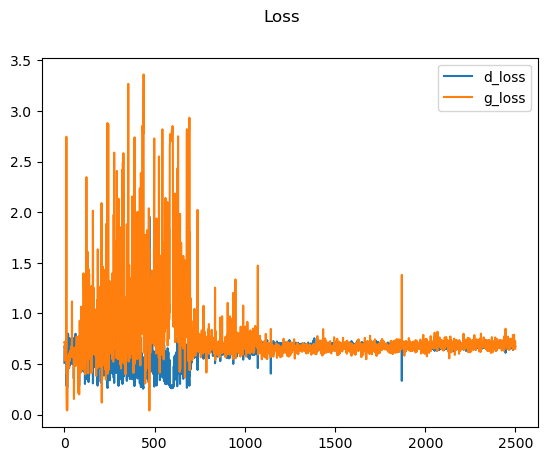

In [36]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

# 5. Test Out the Generator

### 5.1 Generate Images

In [37]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 57ms/step


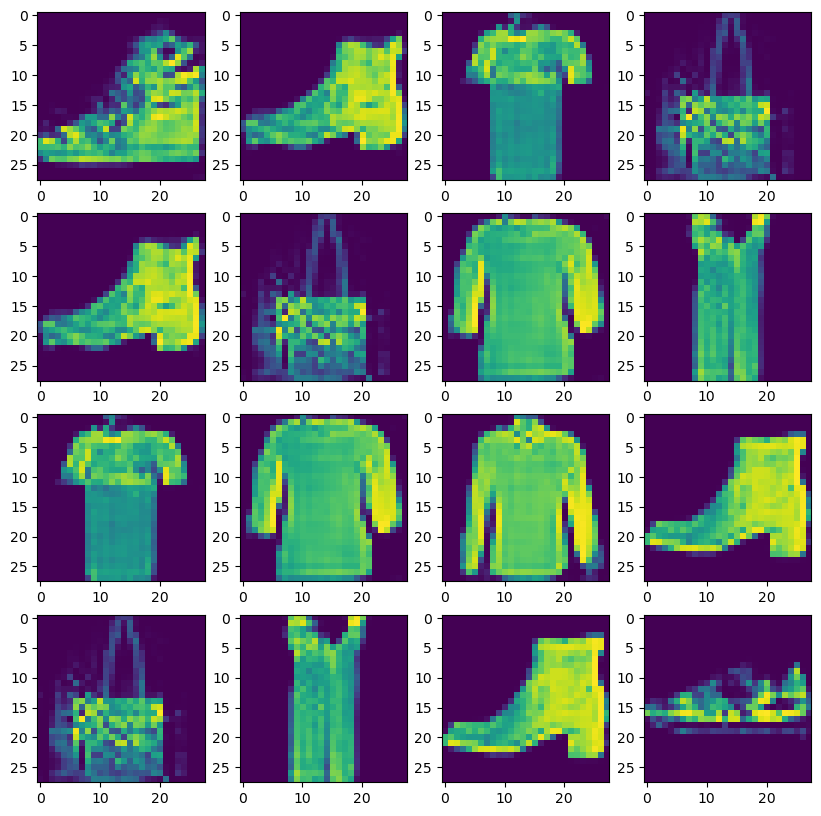

In [38]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the Model

In [39]:
generator.save('generator.tf')
discriminator.save('discriminator.tf')

INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: generator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


INFO:tensorflow:Assets written to: discriminator.tf\assets


### 5.3 loading the saved model

In [40]:
generator.load_weights("generator.tf")
discriminator.load_weights("discriminator.tf")